[*********************100%***********************]  1 of 1 completed
c:\Users\Admin\anaconda3\envs\stt_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Data Sample: [[1.46206675e+01 7.14660000e+07 1.48579998e+01 1.48833332e+01
  1.42173328e+01]
 [1.40059996e+01 8.05275000e+07 1.43033333e+01 1.44333334e+01
  1.38106670e+01]
 [1.40853329e+01 9.39285000e+07 1.40039997e+01 1.42799997e+01
  1.36140003e+01]
 [1.40633326e+01 4.45260000e+07 1.42233334e+01 1.43186674e+01
  1.39853334e+01]
 [1.40413332e+01 5.16375000e+07 1.41873331e+01 1.42533331e+01
  1.40006666e+01]]
Data Shape: (2538, 5)
Train Data Shape: (2030, 5)
Test Data Shape: (508, 5)
Epoch 1/100, Loss: 0.092299, LR: 0.000500
Epoch 2/100, Loss: 0.010357, LR: 0.000500
Epoch 3/100, Loss: 0.007816, LR: 0.000500
Epoch 4/100, Loss: 0.006458, LR: 0.000500
Epoch 5/100, Loss: 0.005309, LR: 0.000500
Epoch 6/100, Loss: 0.004173, LR: 0.000500
Epoch 7/100, Loss: 0.003227, LR: 0.000500
Epoch 8/100, Loss: 0.002930, LR: 0.000500
Epoch 9/100, Loss: 0.002406, LR: 0.000500
Epoch 10/100, Loss: 0.002196, LR: 0.000500
Epoch 11/100, Loss: 0.002025, LR: 0.000500
Epoch 12/100, Loss: 0.001908, LR: 0.000500
Epo

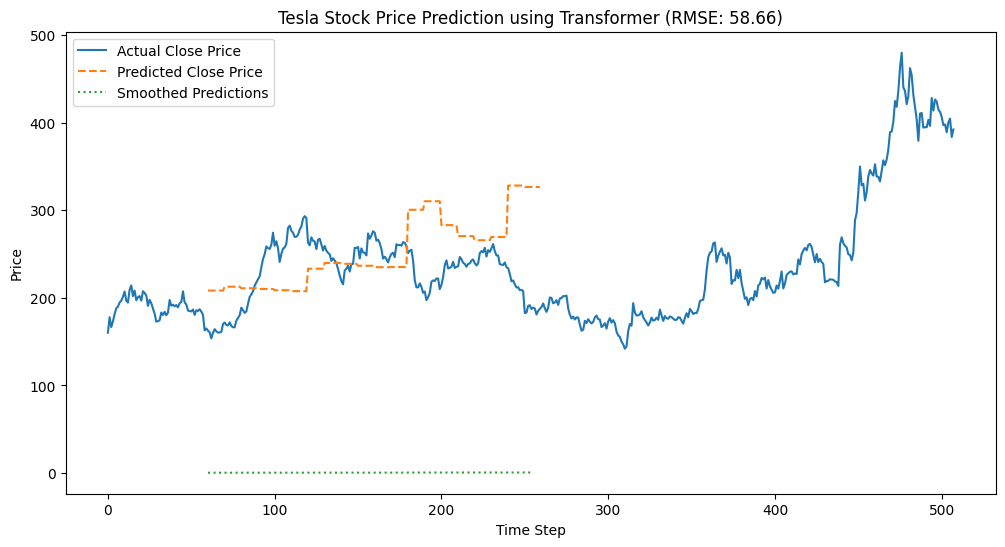

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

# 1. 데이터 로딩 및 전처리
def load_and_preprocess_data(ticker, start_date, end_date, features=['Close', 'Volume', 'Open', 'High', 'Low'], split_ratio=0.8):
    df = yf.download(ticker, start=start_date, end=end_date)
    data = df[features].values  # [num_samples, num_features]
    print(f"Data Sample: {data[:5]}")
    print(f"Data Shape: {data.shape}")

    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    split_idx = int(len(data_scaled) * split_ratio)
    train_data = data_scaled[:split_idx]
    test_data = data_scaled[split_idx:]
    print(f"Train Data Shape: {train_data.shape}")
    print(f"Test Data Shape: {test_data.shape}")

    return train_data, test_data, scaler

"""
이전과 달라진 부분 없다. data를 다운로드하고 MinMaxScaler를 통해 정규화한 후 train_data와 test_data로 분리하여 반환하는 함수이다. 
"""

# 2. Dataset 및 DataLoader 구성 (멀티스텝 예측 버전)
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, pred_length):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_length = seq_length
        self.pred_length = pred_length
    
    def __len__(self):
        return len(self.data) - self.seq_length - self.pred_length + 1
    
    def __getitem__(self, idx):
        src = self.data[idx: idx+self.seq_length]
        tgt = self.data[idx+self.seq_length: idx+self.seq_length+self.pred_length]
        return src, tgt
    
"""
create_dataloader() 함수에서 호출하는 TimeSeriesDataset(Dataset) 클래스이다.

*. 여기서는 단일 스탭 예측에서 멀티 스텝 예측으로 target 부분이 변경되었다. 변경된 세부 내용은 아래와 같다.

1) __init__ : data를 torch.tensor로 변환하고 seq_length와 pred_length를 저장한다. 여기서 data에는 train_data가 전달된다.
2) __len__ : 데이터의 길이(유효 샘플 개수)를 반환한다. 여기서는 seq_length와 pred_length를 고려하여 반환한다.
    전체 데이터 길이에서 seq_length와 pred_length를 빼는 이유
        - seq_length는 입력 시퀀스 길이고, pred_length는 예측할 미래 시점의 길이이다.
        - 이 방법은 멀티 스텝 예측 방법이며, 
        - 예를 들어, seq_length=50, pred_length=10이라면, 0~49번째 데이터로 50~59번째 데이터를 예측하고, 
          10~49번째 데이터 + 50~59번째 데이터로 60~69번째 데이터를 예측하는 식으로 진행한다.

3) __getitem__ : 인덱스를 입력받아 해당 인덱스에 대한 데이터를 반환한다. 
    src는 seq_length만큼의 데이터를 반환하고, 
    tgt는 seq_length만큼의 데이터 이후부터 pred_length만큼의 데이터를 반환한다.
"""

def create_dataloader(data, seq_length, pred_length, batch_size, shuffle=True):
    dataset = TimeSeriesDataset(data, seq_length, pred_length)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

"""
create_dataloader() 함수는 TimeSeriesDataset을 활용하여 data set을 만들고,
DataLoader를 통해 batch_size 만큼 데이터를 불러올 수 있는 loader 객체를 생성한다.

여기서 dataset은 train_data를 TimeSeriesDataset 클래스로 변환한 객체이다.
그리고 src, tgt를 반환하는데, 이는 TimeSeriesDataset 클래스의 __getitem__ 메서드에서 정의한 대로 반환된다.
따라서 loader를 통해 데이터를 불러올 때마다 src와 tgt가 batch_size만큼 튜플 형태로 반환된다.

loader의 shape는 다음과 같다.
    - src : [batch_size, seq_length, input_dim]
    - tgt : [batch_size, pred_length, input_dim]
"""

# 3. Transformer 기반 시계열 예측 모델 정의 (멀티스텝 예측 지원)
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout
        )
        self.fc_out = nn.Linear(d_model, input_dim)

    def forward(self, src, tgt):
        # src: [S, N, input_dim], tgt: [T, N, input_dim]
        src_emb = self.embedding(src)   # [S, N, d_model]
        tgt_emb = self.embedding(tgt)     # [T, N, d_model]
        output = self.transformer(src_emb, tgt_emb)  # [T, N, d_model]
        return self.fc_out(output)      # [T, N, input_dim]

"""
TimeSeriesTransformer 클래스는 nn.Module을 상속받아 정의된 클래스이다. 모델 구조는 이전과 달라진 부분은 없다. 
"""

# 4. 모델 학습 함수 (수정된 Loss Function 및 Teacher Forcing)
def train_model(model, train_loader, device, epochs, learning_rate=0.0005, teacher_forcing_ratio=0.2):
    model.train()
    criterion = nn.HuberLoss()  # Huber Loss로 변경
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
    
    for epoch in range(epochs):
        epoch_loss = 0
        for src, tgt in train_loader: # batch가 돌아감 (src, tgt)
            src = src.to(device)   # [batch, seq_length, input_dim]
            tgt = tgt.to(device)   # [batch, pred_length, input_dim]
            
            src = src.transpose(0, 1)  # [seq_length, batch, input_dim]
            batch_size = src.size(1)
            input_dim = src.size(2)
            pred_length = tgt.size(1)
            
            # Teacher Forcing 결정
            use_teacher_forcing = True if np.random.rand() < teacher_forcing_ratio else False
            if use_teacher_forcing:
                start_token = torch.zeros(1, batch_size, input_dim).to(device)
                tgt_transposed = tgt.transpose(0, 1)  # [pred_length, batch, input_dim]
                decoder_input = torch.cat([start_token, tgt_transposed[:-1]], dim=0) # 배치마다 디코더 입력에 start_token을 추가
            else:
                decoder_input = torch.zeros(pred_length, batch_size, input_dim).to(device) # 배치마다 디코더 입력에 start_token을 추가
            
            optimizer.zero_grad()
            output = model(src, decoder_input)  # [pred_length, batch, input_dim]
            loss = criterion(output, tgt.transpose(0, 1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.6f}, LR: {current_lr:.6f}")

""" 
 디코더 입력: 시작 토큰(0벡터) + 타겟 시퀀스의 앞쪽 토큰들
start_token = torch.zeros(1, batch_size, input_dim).to(device)
tgt_transposed = tgt.transpose(0, 1)   [pred_length, batch, input_dim]
decoder_input = torch.cat([start_token, tgt_transposed[:-1]], dim=0)   [pred_length + 1, batch, input_dim]

 Slicing tgt_transposed[:-1] is equivalent to removing the last element of tgt_transposed
 슬라이싱 문법 [start:end]을 사용하면, 기본적으로 첫 번째 차원(시간 차원)이 조작됩니다.
 tgt_transposed : [pred_length, batch, input_dim]
 tgt_transposed[:-1] : [pred_length-1, batch, input_dim]

 decoder_input : start_token(0벡터) + tgt_transposed[:-1] = [pred_length, batch, input_dim]
 decoder_input : [1, batch, input_dim] + [pred_length-1, batch, input_dim] = [pred_length, batch, input_dim]
else:
 teacher forcing 없이 0벡터만 사용
decoder_input = torch.zeros(pred_length, batch_size, input_dim).to(device)

 decoder_input : [pred_length, batch, input_dim]
"""

# 5. 미래 예측 (결과 Smoothing 추가)
def predict_future(model, test_data, seq_length, pred_length, total_predictions, device, smooth_window=5):
    model.eval()
    test_input = torch.tensor(test_data[:seq_length], dtype=torch.float32).to(device)  # [seq_length, input_dim]
    predictions = []
    with torch.no_grad():
        steps = total_predictions // pred_length
        remainder = total_predictions % pred_length
        for _ in range(steps):
            src = test_input.unsqueeze(1)  # [seq_length, 1, input_dim]
            decoder_input = torch.zeros(pred_length, 1, test_input.size(-1)).to(device)
            out = model(src, decoder_input)    # [pred_length, 1, input_dim]
            out = out.squeeze(1)               # [pred_length, input_dim]
            predictions.append(out.cpu().numpy())
            test_input = torch.cat([test_input[pred_length:], out], dim=0)
        if remainder > 0:
            src = test_input.unsqueeze(1)
            decoder_input = torch.zeros(remainder, 1, test_input.size(-1)).to(device)
            out = model(src, decoder_input)
            out = out.squeeze(1)
            predictions.append(out.cpu().numpy())
        predictions = np.concatenate(predictions, axis=0)
    
    # Smoothing 예측 결과
    smoothed_predictions = np.convolve(predictions[:, 0], np.ones(smooth_window)/smooth_window, mode='valid')
    return predictions, smoothed_predictions

# 6. 시각화 함수 (RMSE 추가)
def plot_predictions(actual, predictions, smoothed_predictions, seq_length):
    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(actual[seq_length:seq_length + len(predictions), 0], predictions[:, 0]))
    plt.figure(figsize=(12,6))
    plt.plot(actual[:, 0], label="Actual Close Price")
    plt.plot(range(seq_length, seq_length + len(predictions)), predictions[:, 0], 
             label="Predicted Close Price", linestyle="dashed")
    plt.plot(range(seq_length, seq_length + len(smoothed_predictions)), smoothed_predictions, 
             label="Smoothed Predictions", linestyle="dotted")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.title(f"Tesla Stock Price Prediction using Transformer (RMSE: {rmse:.2f})")
    plt.legend()
    plt.show()

# 7. 메인 실행 함수
def main():
    # 설정값
    ticker = "TSLA"
    start_date = "2015-01-01"
    end_date = "2025-02-05"
    seq_length = 60
    pred_length = 10
    batch_size = 32
    epochs = 100
    total_predictions = 200
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 데이터 로딩 및 전처리
    train_data, test_data, scaler = load_and_preprocess_data(
        ticker, start_date, end_date,
        features=['Close', 'Volume', 'Open', 'High', 'Low'],
        split_ratio=0.8
    )
    
    # DataLoader 생성
    train_loader = create_dataloader(train_data, seq_length, pred_length, batch_size)
    
    # 모델 생성
    model = TimeSeriesTransformer(input_dim=5, d_model=256, nhead=4, num_layers=4).to(device)
    
    # 모델 학습
    train_model(model, train_loader, device, epochs, learning_rate=0.0005, teacher_forcing_ratio=0.2)
    
    # 미래 예측
    predictions, smoothed_predictions = predict_future(
        model, test_data, seq_length, pred_length, total_predictions, device, smooth_window=5
    )
    predictions_inverse = scaler.inverse_transform(predictions)
    actual_test = scaler.inverse_transform(test_data)
    
    # 결과 시각화
    plot_predictions(actual_test, predictions_inverse, smoothed_predictions, seq_length)

if __name__ == "__main__":
    main()